In [1]:
from concurrent.futures.process import ProcessPoolExecutor

import satpy
import numpy as np
import matplotlib.pyplot as plt
import xarray
import pandas
import earthaccess
import os
from pathlib import Path
from datetime import datetime
import glob
from pykdtree.test_tree import test3d_8n_ub_leaf20
from skyfield.api import EarthSatellite
from skyfield.api import load, wgs84
from skyfield.iokit import parse_tle_file
from collections import defaultdict
from datetime import timedelta
from sat_orbits import *
from sat_info import *


In [2]:
# concatenate tle files together
tle_dir = Path("~/Downloads/").expanduser()

ts = load.timescale()
satellites = []

for tle_path in tle_dir.glob("sat00*"):
    with load.open(str(tle_path)) as f:
        satellites.extend(parse_tle_file(f, ts))

In [3]:
satellites

[<EarthSatellite catalog #27424 epoch 2023-01-01 03:38:24 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-01 14:03:18 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-01 19:57:54 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-01 21:41:14 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-02 04:35:11 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-02 14:47:22 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-02 19:03:21 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-02 20:59:23 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-03 05:17:43 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-03 10:24:20 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-03 19:45:10 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-04 00:59:33 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-04 11:04:28 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-04 20:26:05 UTC>,
 <EarthSatellite catalog #27424 epoch 2023-01-04 20:26:05 UTC>,
 <EarthSatellite catalog #27424 epoch 20

Plot satellite orbits historically based on TLE and using swath width find intersections of all three satellites within a certain time distinction... convert code to a class

In [4]:
analyzer = HistoricalOrbitAnalyzer(satellites, satellite_names)

In [5]:
sat = analyzer.get_satellite_history('aqua')[3589]
sattime = analyzer.get_satellite_history('aqua')[3589].epoch
sat.at(sattime).is_sunlit(load('de421.bsp'))
sats = analyzer.get_satellite_history('aqua')[slice(3588,3590)]

In [6]:
sats

[<EarthSatellite catalog #27424 epoch 2025-03-14 13:40:04 UTC>,
 <EarthSatellite catalog #27424 epoch 2025-03-14 20:04:11 UTC>]

In [6]:
analyzer.ground_track('aqua', )

[<EarthSatellite catalog #27424 epoch 2025-03-14 13:40:04 UTC>,
 <EarthSatellite catalog #27424 epoch 2025-03-14 20:04:11 UTC>]

In [102]:
timedelta = sats[1].epoch.utc_datetime()-sats[0].epoch.utc_datetime()

In [103]:
timedelta

datetime.timedelta(seconds=23046, microseconds=544220)

In [104]:
timedelta.total_seconds()//60

384.0

In [9]:
geocentric = sat.at(sattime)

In [26]:
sp = wgs84.subpoint_of(geocentric)

In [28]:
sp

<GeographicPosition WGS84 latitude +21.6984 N longitude -86.0012 E elevation 0.0 m>

In [ ]:
for i, sat in enumerate(sats):
    t0 = sat.epoch

    if i < len(sats) - 1:
        t1 = sats[i + 1].epoch
        t_end = self.ts.tt_jd(0.5 * (t0.tt + t1.tt))
        print(t_end)
    else:
        t_end = self.ts.tt_jd(t0.tt + max_days_last)
        print('else', t_end)
    t = self.ts.tt_jd(
        np.linspace(t0.tt, t_end.tt, points_per_tle)
    )


In [48]:
t_initial = sats[0].epoch
t_initial.utc_datetime()
t_end = sats[0+1].epoch

In [50]:
ts = load.timescale()
midpoint_time = ts.tt_jd(0.5 * (t_initial.tt + t_end.tt))
print(t_initial.utc_datetime())
print(t_end.utc_datetime())
print(midpoint_time.utc_datetime())

2025-03-14 13:40:04.497589+00:00
2025-03-14 20:04:11.041809+00:00
2025-03-14 16:52:07.769678+00:00


In [56]:
points_per_tle = 300
t = ts.tt_jd(
                np.linspace(t_initial.tt, t_end.tt, points_per_tle)
            )

In [57]:
print(t.utc_datetime())

[datetime.datetime(2025, 3, 14, 13, 40, 4, 497600, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 41, 21, 576362, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 42, 38, 655082, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 43, 55, 733844, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 45, 12, 812565, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 46, 29, 891326, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 47, 46, 970047, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 49, 4, 48808, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 50, 21, 127529, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 51, 38, 206290, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 52, 55, 285051, tzinfo=datetime.timezone.utc)
 datetime.datetime(2025, 3, 14, 13, 54, 12, 363772, tzinfo=datetime.timezone.utc)
 datetime.datetime(

In [77]:
lat = wgs84.subpoint_of(sat.at(t)).latitude.degrees
lon = wgs84.subpoint_of(sat.at(t)).longitude.degrees
print(lat)
print()
print(lon)


[ 58.93306103  63.39866821  67.77911615  72.01482305  75.97705468
  79.35906052  81.44546998  81.25526414  78.90491468  75.40221404
  71.38548818  67.122465    62.72686154  58.25217846  53.72621785
  49.16471089  44.57721171  39.96992591  35.34713094  30.71197977
  26.06693051  21.41402995  16.75506875  12.09167428   7.4253898
   2.75769323  -1.90995948  -6.57613792 -11.23940442 -15.89831844
 -20.5513973  -25.19708844 -29.83371997 -34.45939265 -39.07185272
 -43.66823383 -48.24467811 -52.79562952 -57.31260892 -61.78181019
 -66.17918439 -70.45938142 -74.52834622 -78.16982307 -80.86126621
 -81.63181359 -80.02622976 -76.88945119 -73.0498706  -68.88572364
 -64.55393504 -60.12537498 -55.63550652 -51.10373705 -46.54150024
 -41.95600216 -37.3520616  -32.73312101 -28.10178572 -23.46016893
 -18.81008308 -14.15315524  -9.49092037  -4.8248492   -0.15639707
   4.51299672   9.18187563  13.84877174  18.51217053  23.17048982
  27.82204117  32.46493851  37.09699729  41.71551963  46.31698987
  50.896503

In [59]:
lat, lon = wgs84.latlon_of(geocentric)
print('time --- ' + str(sattime) + '    ---- > UTC ----> ' + str(sattime.utc_datetime()))
print('latitude --- ' + str(lat))
print('longitude --- ' + str(lon))


AttributeError: 'Time' object has no attribute 'center'

In [37]:
lat.degrees

np.float64(21.69838961838215)

In [5]:
dict = analyzer.ground_track('aqua', slice(3588,3590))

In [6]:
dict

{'lat': array([ 58.93313549,  62.42528893,  65.87112046, ..., -50.42452197,
        -53.96335804, -57.47990272], shape=(1823,)),
 'lon': array([-0.69764257, -3.16305999, -6.20833891, ..., 87.666213  ,
        86.00994935, 84.09475175], shape=(1823,)),
 'time': array([datetime.datetime(2025, 3, 14, 13, 40, 4, 497600, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 3, 14, 13, 41, 4, 671364, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 3, 14, 13, 42, 4, 845087, tzinfo=datetime.timezone.utc),
        ...,
        datetime.datetime(2025, 3, 15, 20, 2, 10, 874916, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 3, 15, 20, 3, 10, 958356, tzinfo=datetime.timezone.utc),
        datetime.datetime(2025, 3, 15, 20, 4, 11, 41796, tzinfo=datetime.timezone.utc)],
       shape=(1823,), dtype=object)}

In [80]:
print(dict['lat'][0])
print(dict['lon'][0])
print(dict['time'][300])

58.93313549298481
-0.6976425692891582
2025-03-14 14:54:19.370842+00:00


(<Figure size 800x400 with 1 Axes>,
 <Axes: title={'center': 'Sentinel_2b TLE Update Frequency'}, xlabel='Time Between Consecutive TLEs (hours)', ylabel='Frequency'>)

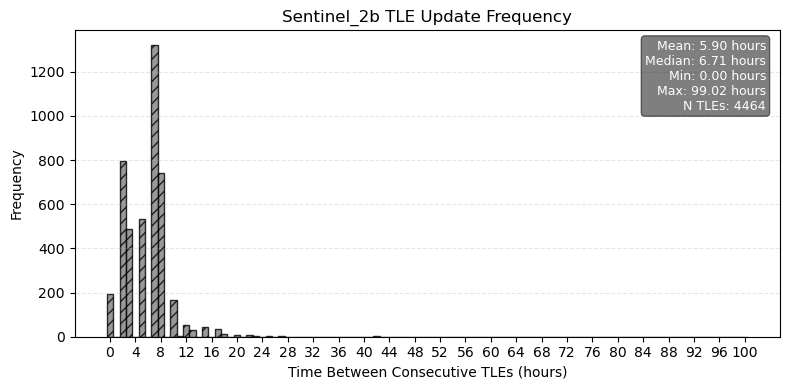

In [5]:
analyzer.plot_tle_update_frequency('sentinel_2b')

In [38]:
if lat.degrees in dict['lat']:
    print("yes")

In [39]:
dict['lat']

array([58.93313549, 59.79840401, 60.66151979, ...,  1.50744767,
       48.46547647, 79.47551082], shape=(1554,))

In [ ]:
# analyzer.get_satellite_history('terra')
# terra_track = analyzer.ground_track('terra')
aqua_track = analyzer.ground_track('aqua')
# landsat8_track = analyzer.ground_track('landsat8')
# sentinel2a_track = analyzer.ground_track('sentinel2a')
noaa20_track = analyzer.ground_track('noaa20')
# landsat9_track= analyzer.ground_track('landsat9')
# noaa21_track = analyzer.ground_track('noaa21')
sentinel2c_track = analyzer.ground_track('sentinel2c')

In [ ]:
print(aqua_track['lats'][120])
print(noaa20_track['lats'][110])

In [ ]:
if not -45 <= aqua_track['lats'][120] <= 45 and -45 <= noaa20_track['lats'][120] <= 45:
    print('outside of bound')

In [ ]:
gt = groundtrack_intersections(aqua_track, noaa20_track)
gt

In [ ]:
lambda x: x[0]

In [ ]:
sentinel2c_track['times']

In [ ]:
l = (-45, 45)

In [ ]:
l[0]

In [ ]:
l[1]

In [ ]:
test  =  (1, 2, 3, 4, 5, 6, 7)

In [ ]:
t, _, _, _, _, _, _ = test

In [ ]:
groundtrack_intersections(aqua_track, noaa20_track)
